In [11]:
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

# Simple Random Walk

In [12]:
class RandomWalk:
    def __init__(self, states):
        self.state_space = states
        self.action_space = 2
        self.init = self.state_space // 2
        self.player = self.init
        
    def reset(self):
        self.player = self.init
        return self.player
    
    def step(self):
        if np.random.rand() < 0.5:
            self.player -= 1
        else:
            self.player += 1
        
        if self.player == self.state_space-1:
            reward = 1
            done = True
        elif self.player == 0:
            reward = -1
            done = True
        else:
            reward = 0
            done = False
            
        return self.player, reward, done
    
    def p(self, state):
        l = []
        l.append((1/2, 1 if state + 2 == self.state_space else 0, state + 1))
        l.append((1/2, -1 if state - 1 == 0 else 0, state - 1))
        return l


In [13]:
class ValueIteration:
    def __init__(self, env, theta=0.1, gamma=1):
        self.env = env
        self.V = np.zeros(self.env.state_space)
        self.gamma = gamma
        self.theta = theta

    def iterate(self):
        done = False
        pbar = tqdm()
        while not done:
            pbar.update(1)
            new_V = np.zeros(self.env.state_space)
            for s in range(1,self.env.state_space-1):
                q = np.zeros(2)
                list = self.env.p(s)
                for (P, reward, s_p) in list:
                    new_V[s] += P * (reward + self.gamma * self.V[s_p])
            delta = np.max(np.abs(new_V - self.V))
            self.V = new_V
            if delta < self.theta:
                done = True
        pbar.close()

    def value(self):
        return self.V


In [14]:
rw = RandomWalk(21)

In [15]:
vi = ValueIteration(rw, 0.000000001, gamma=1)

In [16]:
vi.iterate()
real_values = vi.V

358it [00:00, 6762.36it/s]


In [17]:
real_values

array([ 0.        , -0.9       , -0.79999999, -0.69999999, -0.59999999,
       -0.49999999, -0.39999999, -0.29999999, -0.19999999, -0.1       ,
        0.        ,  0.1       ,  0.19999999,  0.29999999,  0.39999999,
        0.49999999,  0.59999999,  0.69999999,  0.79999999,  0.9       ,
        0.        ])

In [8]:
class nStepTD:
    def __init__(self, env, n, alpha=0.4, gamma=1):
        self.env = env
        self.alpha = alpha
        self.gamma = gamma
        self.n = n
        self.max_len = 10_000
        self.V = np.zeros(env.state_space)
        
    def reset(self):
        self.V = np.zeros(self.env.state_space)
        
    def estimate(self, n_episodes=1000):
        for i in range(n_episodes):
            gammas = np.power(self.gamma, range(self.max_len))
            states =[]
            rewards = []

            state = self.env.reset()
            states.append(state)

            T = np.inf
            t = 0
            while True:
                if t < T:
                    s_p, reward, done = self.env.step()
                    rewards.append(reward)
                    if done:
                        T = t + 1
                tau = t - self.n + 1
                if tau >= 0:
                    G = np.sum(gammas[:min(tau+self.n,T) - tau] * rewards[tau:min(tau+self.n,T)])
                    if tau + n < T:
                        G += np.power(self.gamma,self.n) * self.V[s_p]
                    self.V[states[tau]] += self.alpha * (G - self.V[states[tau]])
                if tau == T - 1:
                    break
                t += 1
                state = s_p
                states.append(state)
            
    def repeat(self, n_runs, n_episodes):
        avg = np.zeros(n_runs)
        for i in range(n_runs):
            self.reset()
            self.estimate(n_episodes)
            avg[i] = np.sqrt(((self.V - real_values) ** 2).mean())
        return avg.mean()
                

In [9]:
ns = [1, 2, 4, 8, 16, 32, 64, 128, 256, 512]
alphas = [i * 0.1 for i in range(11)]


In [ ]:
plt.figure(figsize=(12, 8))

for n in tqdm(ns):
    res = np.zeros(len(alphas))
    for a in range(11):
        rw = RandomWalk(21)
        td = nStepTD(rw, n, alpha=alphas[a])
        res[a] = td.repeat(100,10)
    plt.plot(alphas, res, label="n = " + str(n))
        
plt.xlabel('Alpha')
plt.ylabel('Average RMS error')
plt.legend()
plt.show()

# State Aggregation

In [21]:
class LongRandomWalk(RandomWalk):
    def __init__(self, states):
        self.state_space = states + 2
        self.init = self.state_space // 2
        self.player = self.init
        
    def step(self):
        if np.random.rand() < 0.5:
            rand = np.floor(np.random.rand() * (-100))
        else:
            rand = np.floor(np.random.rand() * (+100)) + 1
        
        self.player = int(min(max(self.player + rand, 0), self.state_space-1))
        
        if self.player == 0:
            reward = -1
            done = True
        elif self.player == self.state_space-1:
            reward = 1
            done = True
        else:
            reward = 0
            done = False
            
        return self.player, reward, done

In [22]:
n_states = 1000

lrw = LongRandomWalk(n_states)

In [35]:
# sample trajectory
lrw.reset()
while True:
    state, rew, done = lrw.step()
    print(state, rew, done)
    if done:
        break;

486 0 False
479 0 False
432 0 False
391 0 False
412 0 False
404 0 False
306 0 False
346 0 False
380 0 False
304 0 False
301 0 False
323 0 False
228 0 False
139 0 False
207 0 False
212 0 False
117 0 False
53 0 False
12 0 False
0 -1 True


In [249]:
real_values = np.array([i/500.0 - 1 for i in range(0,1000)])

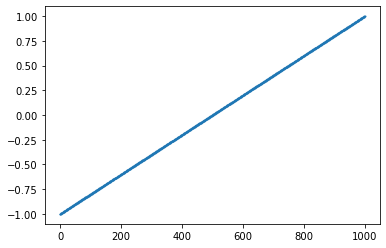

In [250]:
plt.scatter(range(0,1000), real_values, s=1)
plt.show()

In [257]:
class GradientMC():
    def __init__(self, env, n_features, feature_vector, gamma=1, alpha=1e-4):
        self.w = np.zeros(n_features)
        self.env = env
        self.feature_vector = feature_vector
        self.gamma = gamma
        self.alpha = alpha
        
    def reset(self):
        self.w = np.zeros(n_features)
        
    def estimate(self, n_episodes):
        err = np.zeros(n_episodes)
        state = self.env.reset()
        for e in range(n_episodes):
            G = 0
            episode = self.generate_episode()
            for t in reversed(range(len(episode))):
                state, reward = episode[t]
                G = self.gamma * G + reward
                v = self.w * self.feature_vector(state)
                self.w += self.alpha * (G - v) * self.feature_vector(state)
            err[e] = self.error()
        return err
    
    def error(self):
        approx = np.sum([self.w * self.feature_vector(i+1) for i in range(0,1000)])
        return np.sqrt(((approx - real_values) ** 2).mean())
            
    def generate_episode(self):
        episode = []
        state = self.env.reset()
        while True:
            s_p, rew, done = self.env.step()
            episode.append((state, rew))
            if done:
                break;
            state = s_p
        return episode
        
    def iterate(self, n_runs, n_episodes):
        err = np.zeros(n_episodes)
        for i in tqdm(range(n_runs)):
            self.reset()
            err += self.estimate(n_episodes)
        return err/n_episodes
            

## One Tiling

In [258]:
tile_size = 200
n_features = n_states // tile_size


In [259]:
def feature_vector_one_tile(state):
    features = np.zeros(n_features + 2)
    x = (state - 1) // tile_size + 1
    features[x] = 1
    return features[1:-1]

In [260]:
## TEST
np.testing.assert_array_equal(feature_vector_one_tile(state=0), np.zeros(n_features))

np.testing.assert_array_equal(feature_vector_one_tile(state=1001), np.zeros(n_features))

a = np.zeros(n_features)
a[0] = 1
np.testing.assert_array_equal(feature_vector_one_tile(state=1), a)

a = np.zeros(n_features)
a[0] = 1
np.testing.assert_array_equal(feature_vector_one_tile(state=200), a)

a = np.zeros(n_features)
a[1] = 1
np.testing.assert_array_equal(feature_vector_one_tile(state=201), a)


In [261]:
n_states = 1000

lrw = LongRandomWalk(n_states + 2)
gmc = GradientMC(lrw, n_features, feature_vector_one_tile)

In [262]:
gmc.estimate(5000)

array([ 1.25985646,  2.77512646,  0.69817641, ..., 54.12073632,
       48.75453266, 49.97822463])

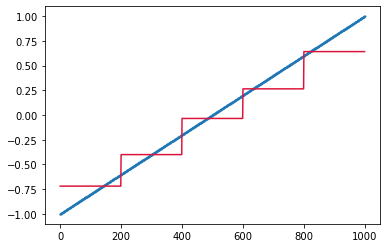

In [263]:
plt.plot(gmc.w.repeat(tile_size, axis=0), 'crimson')
plt.scatter(range(0,1000), real_values, s=1)
plt.show()

In [264]:
VE_one_tile = gmc.iterate(30, 5000)

100%|██████████| 30/30 [08:25<00:00, 16.85s/it]


## Tile Coding

In [265]:
n_features = (n_states // tile_size + 1) * 50
n_tiles = (n_states // tile_size + 1)
tile_shift = 4 # states

In [266]:
def feature_vector_tile_coding(state):
    features = np.zeros(n_features)
    if state == n_states + 1 or state == 0:
        return features
    
    tile = (state - 1) // tile_size
    sec = (state - tile * 200) // 4 + 1
    features = np.zeros(n_features)
    indexes = [tile + i*n_tiles for i in range(50-sec)] + \
        [1 + tile + (50-sec + i)*n_tiles for i in range(sec)]
    features[indexes] = 1
    return features

In [267]:
## Feature Vector TEST
np.testing.assert_array_equal(feature_vector_tile_coding(state=0), np.zeros(n_features))

np.testing.assert_array_equal(feature_vector_tile_coding(state=1001), np.zeros(n_features))

a = []
b = [1,0,0,0,0,0]
c = [0,1,0,0,0,0]
for i in range(49):
    a += b
a += c
np.testing.assert_array_equal(feature_vector_tile_coding(state=1), a)

np.testing.assert_array_equal(feature_vector_tile_coding(state=3), a)


a = []
b = [1,0,0,0,0,0]
c = [0,1,0,0,0,0]
for i in range(48):
    a += b
a += c+c
np.testing.assert_array_equal(feature_vector_tile_coding(state=4), a)



In [273]:
n_states = 1000

lrw = LongRandomWalk(n_states + 2)
gmc = GradientMC(lrw, n_features, feature_vector_tile_coding, alpha=2e-6)

In [274]:
gmc.estimate(5000)

array([  0.64573114,   3.39715346,   2.58603492, ..., 275.8247287 ,
       275.45362924, 275.13197677])

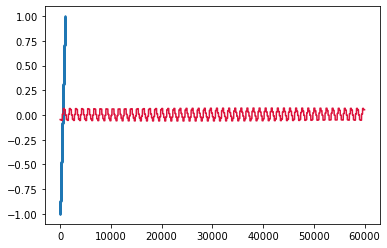

In [275]:
plt.plot(gmc.w.repeat(tile_size, axis=0), 'crimson')
plt.scatter(range(0,1000), real_values, s=1)
plt.show()

In [272]:
VE_tile_coding = gmc.iterate(30, 5000)

  3%|▎         | 1/30 [01:52<54:25, 112.61s/it]


KeyboardInterrupt: 

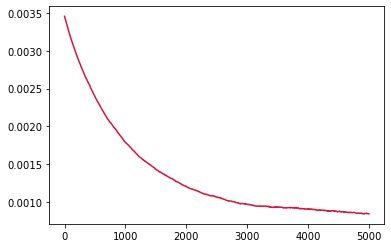

In [213]:
plt.plot(VE_one_tile, 'crimson', label='State aggregation (one tiling)')
plt.plot(VE_tile_coding, 'deepskyblue', label='Tile coding (50 tilings)')
plt.legend()
plt.show()